In [281]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None

### TODO:
- Load sample data from json file
- Fill sample data to Dataframe
- Standardize data
- Bins data to buckets latency **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]***
- Simulator increase[$time_vector] = y - x [$time_vector] (y: last_increament, x: first_increament)
- Simulator rate[$time_vector] = increase()/$time_vector (seconds) -> incre per-second
- Simulator linear interpolation -> Calculate quantile

In [282]:
DATA = []
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
TIME_VECTOR = 5 # second

### Load sample data from json file
Sample format row data:
```python
{"timestamp": "23/01/2024, 10:44:34", "path": "/users", "method": "GET", "service_name": "process_log", "controller_pod": "pod-1", "duration_time": 0.176}
```

In [283]:
import json


def get_data_from_file(filename: str):
    f = open(filename, "r")
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        DATA.append(row)

In [284]:
get_data_from_file("../statics/request_data_with_duration_time.json")

### Fill sample data to Dataframe
Columns list: **[timestamp, path, method, service_name, controller_pod, duration_time]**

In [285]:
# Create dataframe
root_df = pd.DataFrame(DATA)

In [286]:
root_df

,timestamp,path,method,service_name,controller_pod,duration_time
0,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.176
1,"23/01/2024, 10:44:34",/home,GET,process_log,pod-2,0.654
2,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.562
3,"23/01/2024, 10:44:34",/users,GET,process_log,pod-1,0.690
4,"23/01/2024, 10:44:35",/users,GET,process_log,pod-1,0.333
...,...,...,...,...,...,...
14793,"23/01/2024, 11:34:26",/home,GET,process_log,pod-1,0.148
14794,"23/01/2024, 11:34:26",/users,GET,process_log,pod-1,0.145
14795,"23/01/2024, 11:34:26",/users,GET,process_log,pod-2,0.298
14796,"23/01/2024, 11:34:26",/users,GET,process_log,pod-1,0.243


### Standardlize data

In [287]:
# Re format timestamp to  "%d/%m/%Y, %H:%M:%S"
from datetime import datetime
root_df['timestamp'] = root_df['timestamp'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y, %H:%M:%S"))

In [288]:
# Bins data to bucket latency
def bucketing(duration_time):
    res = []
    for bucket in BUCKETS:
        if duration_time <= bucket:
            res.append(bucket)
    res.append("+Inf")
    return res

root_df["le"] = root_df["duration_time"].apply(lambda x: bucketing(x))

In [289]:
root_df

,timestamp,path,method,service_name,controller_pod,duration_time,le
0,2024-01-23 10:44:34,/users,GET,process_log,pod-1,0.176,"[0.25, 0.5, +Inf]"
1,2024-01-23 10:44:34,/home,GET,process_log,pod-2,0.654,[+Inf]
2,2024-01-23 10:44:34,/users,GET,process_log,pod-1,0.562,[+Inf]
3,2024-01-23 10:44:34,/users,GET,process_log,pod-1,0.690,[+Inf]
4,2024-01-23 10:44:35,/users,GET,process_log,pod-1,0.333,"[0.5, +Inf]"
...,...,...,...,...,...,...,...
14793,2024-01-23 11:34:26,/home,GET,process_log,pod-1,0.148,"[0.25, 0.5, +Inf]"
14794,2024-01-23 11:34:26,/users,GET,process_log,pod-1,0.145,"[0.25, 0.5, +Inf]"
14795,2024-01-23 11:34:26,/users,GET,process_log,pod-2,0.298,"[0.5, +Inf]"
14796,2024-01-23 11:34:26,/users,GET,process_log,pod-1,0.243,"[0.25, 0.5, +Inf]"


In [290]:
# Get distinct group for bins value latency for each group
group_dataset = root_df.groupby(['path', 'method', 'service_name', 'controller_pod']).count().reset_index()[['path', 'method', 'service_name', 'controller_pod']]

In [291]:
group_dataset # <- Return all group existed in dataset, next step do bins value of each group into bucket list: **[0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, +Inf]** 

,path,method,service_name,controller_pod
0,/home,GET,process_log,pod-1
1,/home,GET,process_log,pod-2
2,/users,GET,process_log,pod-1
3,/users,GET,process_log,pod-2


In [292]:
from typing import Dict


def bins_value(row, bins_dict: Dict):
    # unwind data from list
    list_le = row['le']
    for le in list_le:
        if le in bins_dict:
            bins_dict[le] += 1
    bins_series = pd.Series(
        data=bins_dict, index=bins_dict.keys()  # type: ignore
    )
    # Join two series
    new_row = pd.concat([row, bins_series])
    return new_row

In [293]:
# Bins value to bucket latency
df_by_group = {}
for idx, dataset in group_dataset.iterrows():
    bins_dict = {k: 0 for k in BUCKETS}
    bins_dict['+Inf'] = 0  # type: ignore
    # Query for each group get dataframe and save it to datastructure
    df_by_group[idx] = root_df.query(
        "path == @dataset['path'] \
                and method == @dataset['method'] \
                and service_name == @dataset['service_name'] \
                and controller_pod == @dataset['controller_pod']")\
        .apply(lambda x: bins_value(x, bins_dict), axis=1)

# Join all group dataframe processed by one dataframe
raw_df = pd.concat(df_by_group.values()).reset_index(drop=True)

In [294]:
# Rename columns
columns_change = {
    0.005: "le_0.005",
    0.01: "le_0.01",
    0.025: "le_0.025",
    0.05: "le_0.05",
    0.1: "le_0.1",
    0.25: "le_0.25",
    0.5: "le_0.5",
    "+Inf": "+Inf"
}
raw_df = raw_df.rename(columns=columns_change)

In [295]:
# Select columns necessary for analysis
list_column_select = ["timestamp", "path", "method", "service_name",
                      "controller_pod"] + [bucket for bucket in columns_change.values()]
raw_df = raw_df[list_column_select]

<Axes: xlabel='timestamp'>

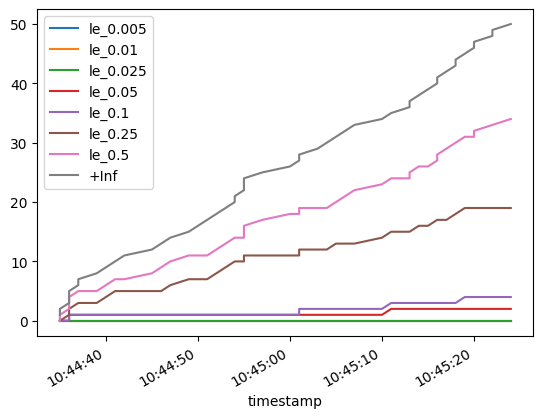

In [296]:
# Check and ensure value calculated is counter for calculate increment
raw_df[0:50][["timestamp"] + [bucket for bucket in columns_change.values()]
             ].plot(kind="line", x="timestamp")

In [297]:
# Group data interval 1 second
# Only consider about latency bucket -> Get newest value increament by second
raw_df = raw_df.groupby(["timestamp", "path", "controller_pod"]).nth(-1).reset_index(drop=True)

In [298]:
group_by_el = ["path", "method", "service_name", "controller_pod"]

In [312]:
raw_df[0:20]

,path,method,service_name,controller_pod,le_0.005,le_0.01,le_0.025,le_0.05,le_0.1,le_0.25,le_0.5,+Inf
timestamp,,,,,,,,,,,,
2024-01-23 10:44:35,/home,GET,process_log,pod-1,0,0,0,0,0,0,1,2
2024-01-23 10:44:36,/home,GET,process_log,pod-1,0,0,0,1,1,2,4,5
2024-01-23 10:44:37,/home,GET,process_log,pod-1,0,0,0,1,1,3,5,7
2024-01-23 10:44:39,/home,GET,process_log,pod-1,0,0,0,1,1,3,5,8
2024-01-23 10:44:40,/home,GET,process_log,pod-1,0,0,0,1,1,4,6,9
2024-01-23 10:44:41,/home,GET,process_log,pod-1,0,0,0,1,1,5,7,10
2024-01-23 10:44:42,/home,GET,process_log,pod-1,0,0,0,1,1,5,7,11
2024-01-23 10:44:45,/home,GET,process_log,pod-1,0,0,0,1,1,5,8,12
2024-01-23 10:44:46,/home,GET,process_log,pod-1,0,0,0,1,1,5,9,13


In [300]:
# Convert to datetime pandas and set datetime columns is index for dataframe
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])
raw_df = raw_df.set_index('timestamp')

In [333]:
bucket_columns = {v: ["first", "last"] for v in columns_change.values()}

# Implement pct change for each bucket
raw_df_rolling = raw_df.groupby(group_by_el).rolling(window="3s").agg(lambda x: (x[-1] - x[0]) / x[0])  # type: ignore

C:\Users\vunv\AppData\Local\Temp\ipykernel_1332\215325719.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  raw_df_rolling = raw_df.groupby(group_by_el).rolling(window="3s").agg(lambda x: (x[-1] - x[0]) / x[0])  # type: ignore


<Axes: xlabel='timestamp'>

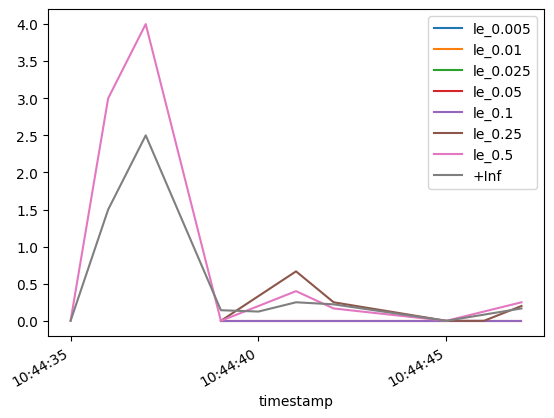

In [339]:
raw_df_rolling[0:10].reset_index().plot(x="timestamp")